<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model performance analysis on COCO 2017 dataset


The following models will be evaluated:

| Model | Backbone | Image Size | Parameters | GFLOPs 
| --- | --- | --- | --- | --- |
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 |
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 |
| Faster R-CNN |  MobileNetV3-Large FPN | 800x800 | 19.4M | 9.2 |
| Faster R-CNN |  ResNet-50 FPN | 800x800 | 41.8M | 269.1 |
| Mask R-CNN |  ResNet-50 FPN | 800x800 | 44.4M | 269.1 |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 |
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 |


### Import packages

In [2]:
# Comment google.colab package if using local runtime
from google.colab import drive

import os

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import textwrap as tw

### Connect to GDrive for storage access

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### Gather evaluation results

In [4]:
gpu =  'gtx960' # Selected gpu to show results for ('gtx960' or 'k80')
results_dir = '/content/drive/MyDrive/object-detection-results/coco2017'
results_files = os.listdir(results_dir)
results_files = [file for file in results_files if ('.csv' in file) and ('coco17' in file) and (gpu in file)]

print('Files found:')

# Gather results
results = pd.DataFrame(columns=['model', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score'])
for file in results_files:
  print(f'\t{file}')
  file_path = os.path.join(results_dir,file)
  results = results.append(pd.read_csv(file_path))
results = results.reset_index().iloc[:,1:-1]  # Drop uneeded columns
results = results.sort_values(['model'])

# Plot variables
markers = ['o','v','^','s','p','P','*','h','X','D','d']
colors = ['tab:blue','tab:blue','tab:orange','tab:green','tab:green','tab:red','tab:red','tab:red','tab:purple','tab:purple','tab:purple']
models = results.model.unique()
models_short = ['FR-CNN MNv3-L','FR-CNN  RN50 FPN','MR-CNN  RN50 FPN', 'SSD300 VGG16', 'SSDlite320 MNv3-L', 'YOLOv3', 'YOLOv3-spp','YOLOv3-tiny','YOLOv5l', 'YOLOv5m', 'YOLOv5s']


Files found:
	coco17_gtx960_yolov3_tiny_metrics.csv
	coco17_gtx960_ssd300_vgg16_metrics.csv
	coco17_gtx960_ssdlite320_mobilenet_v3_large_metrics.csv
	coco17_gtx960_fasterrcnn_resnet50_fpn_metrics.csv


### Create performance table


In [5]:
# perf_table = pd.DataFrame(columns=['model', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score'])])

grouped_results = results.groupby(by=['model'])

# Get model attributes
perf_table = grouped_results.first().iloc[:,:4].reset_index()
model_params = perf_table['model_params'].values
model_gflops = perf_table['model_gflops'].values
fps = perf_table['fps'].values
max_mem = perf_table['max_mem'].values

# Get following model metrics
mAP = results[  # COCO Challenge metric
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_50 = results[  # PASCAL VOC Challenge metric
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
f1 = [2*((mAP[i]*mAR[i])/(mAP[i]+mAR[i])) for i in range(0,len(mAP))]

perf_table['map'] = mAP
perf_table['map_50'] = mAP_50
perf_table['mar'] = mAR
perf_table['f1'] = f1
  
perf_table = perf_table.round(2)  # round to two decimals

perf_table

,model,model_params,model_gflops,fps,max_mem,map,map_50,mar,f1
0,Faster R-CNN ResNet-50 FPN,41.8,257.6,3.50,606.76,0.37,0.59,0.51,0.43
1,SSD300 VGG16,35.6,69.8,14.61,209.81,0.25,0.42,0.36,0.30
2,SSDlite320 MobileNetV3-Large,3.4,1.2,24.42,209.81,0.21,0.34,0.33,0.26
3,YOLOv3-tiny,8.8,13.3,69.65,91.73,0.12,0.22,0.15,0.13


### Plot  fps / mAP or fps / mAR (change parameters)

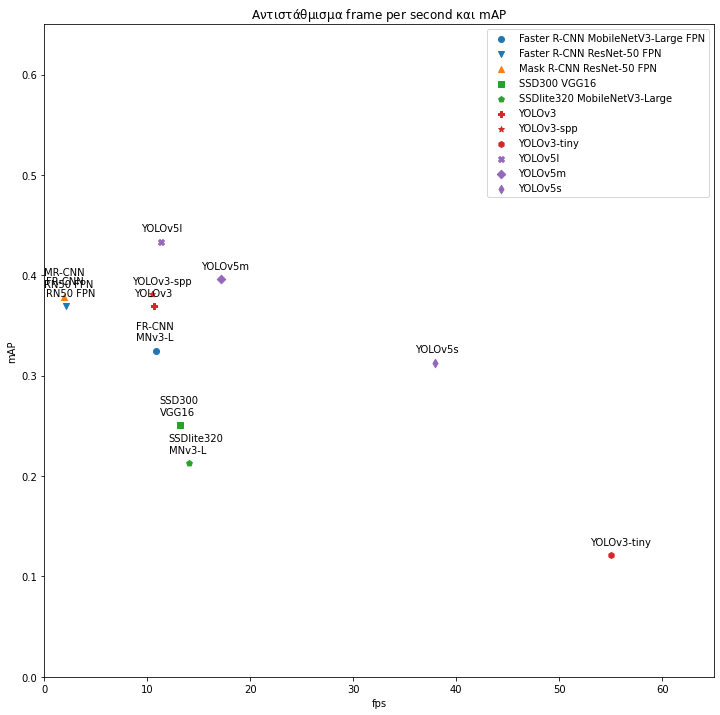

In [ ]:
%matplotlib inline

# Parameters
metric_name = 'avg_precision'
iou = '0.50:0.95'
area = 'all'
max_dets = 100

# Flags
show_iou = True if not iou == '0.50:0.95' else False  # show iou in plot title or not
show_area = True if not area == 'all' else False  # show area in plot title or not
show_max_dets = False  # show max_dets in plot title or not

# Get metric values
metric = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == metric_name) & 
              (results['iou'] == iou) &
              (results['area'] == area) &
              (results['max_dets'] == max_dets)
              ]['score'].values

# Start plotting
plt.figure(figsize=(12,12))

metric_superscript = f'{area},max={max_dets}' if show_area & show_max_dets else area if show_area else f'max={max_dets}' if show_max_dets else ''  # metric superscript for the plot's title
metric_name_short = 'mAP' if metric_name == 'avg_precision' else 'mAR' if metric_name == 'avg_recall' else ''  # metric name for the plot's title
iou_script = f'@[{iou.replace("0.",".")}]' if show_iou else ''  # iou script for plot's title
plt.title('Αντιστάθμισμα frame per second και ' + metric_name_short + '$^{' + metric_superscript + '}$' + iou_script )

plt.ylabel(metric_name_short)
plt.xlabel('fps')

if metric_name == 'avg_precision':
  plt.xlim((0,65))
  plt.ylim((0,0.65))
  
elif metric_name == 'avg_recall':
  plt.xlim((0,65))
  plt.ylim((0,0.75))

for i in range(len(models)):
  # # Point annotation distance tuning
  xytext = (-20,10)
  # if models[i] == 'SSD300 VGG16':
  #   xytext = (-50,0)  # try (-20,10) or (-5,10) or (-50,0)
  # elif models[i] == 'SSDlite320 MobileNetV3-Large':
  #   xytext = (-5,15)  # try (-20,10) or (-5,15)
  # elif models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
  #  xytext = (-20,10) # try (-20,10) or (-55,10)
  # elif models[i] == 'Faster R-CNN ResNet-50 FPN':
  #   xytext = (-50,10)  # try (-50,10)
  # elif models[i] == 'Mask R-CNN ResNet-50 FPN':
  #   xytext = (5,10)  # try (-20,10) or (5,10)
  # elif models[i] == 'YOLOv3-spp':
  #  xytext = (-10,-15)  # try (-20,10) or (-10,10) or (-60,10) or (-10,-15)
  # elif models[i] == 'YOLOv3':
  #   xytext = (-40,5)  # try (-20,15) or (-10,15) or (-40,5)
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (fps[i], metric[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(fps[i],metric[i],marker=markers[i],color=colors[i])

plt.legend(models, scatterpoints=1)

plt.show()

### Plot fps / F1 graph (iou='0.50:0.95', area='all', max detections = 100)

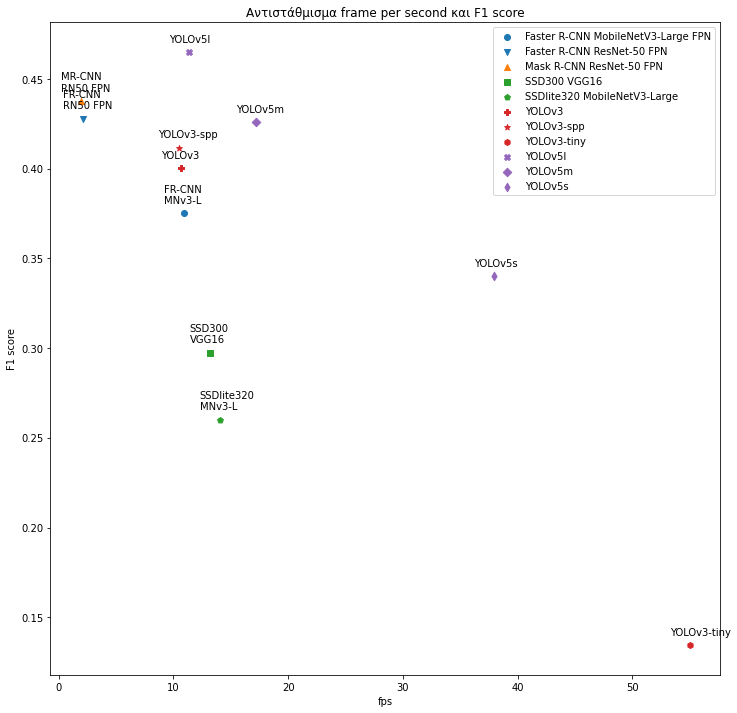

In [ ]:
%matplotlib inline

# Start plotting
plt.figure(figsize=(12,12))

plt.title('Αντιστάθμισμα frame per second και F1 score')
plt.xlabel('fps')
plt.ylabel('F1 score')

for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  # if models[i] == 'Faster R-CNN ResNet-50 FPN':
  #   xytext = (-50,10) 
  # elif models[i] == 'Mask R-CNN ResNet-50 FPN':
  #   xytext = (5,10)
  # elif models[i] == 'YOLOv3':
  #   xytext = (-20,15) 
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (fps[i], f1[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(fps[i], f1[i], marker=markers[i],color=colors[i])

plt.legend(models, scatterpoints=1)

plt.show()

### Plot model parameters / F1

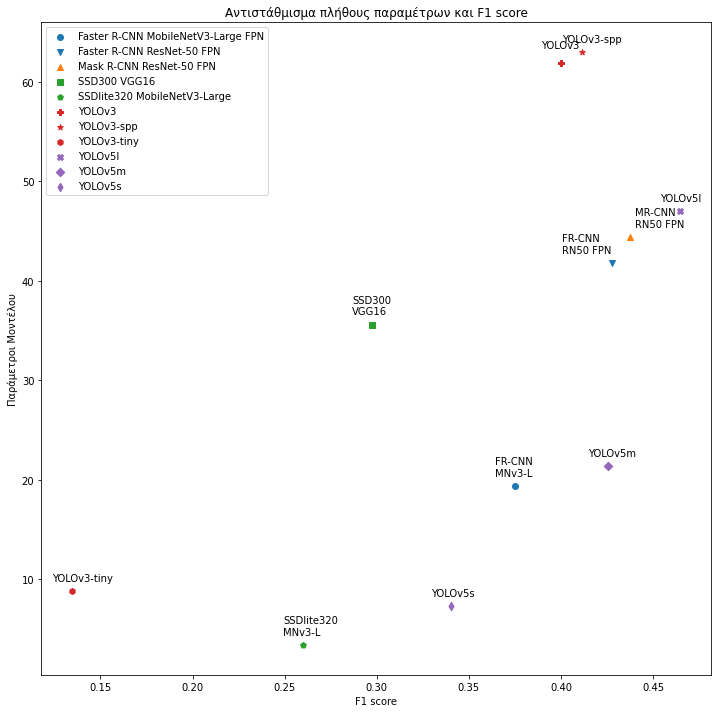

In [ ]:
%matplotlib inline

# Start plotting
plt.figure(figsize=(12,12))

plt.title('Αντιστάθμισμα πλήθους παραμέτρων και F1 score')
plt.xlabel('F1 score')
plt.ylabel('Παράμετροι Μοντέλου')

for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-50,10) 
  elif models[i] == 'Mask R-CNN ResNet-50 FPN':
    xytext = (5,10)
  elif models[i] == 'YOLOv3':
    xytext = (-20,15) 
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (f1[i], model_params[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(f1[i],model_params[i], marker=markers[i],color=colors[i])

plt.legend(models, scatterpoints=1)

plt.show()

### Plot model parameters / gflops

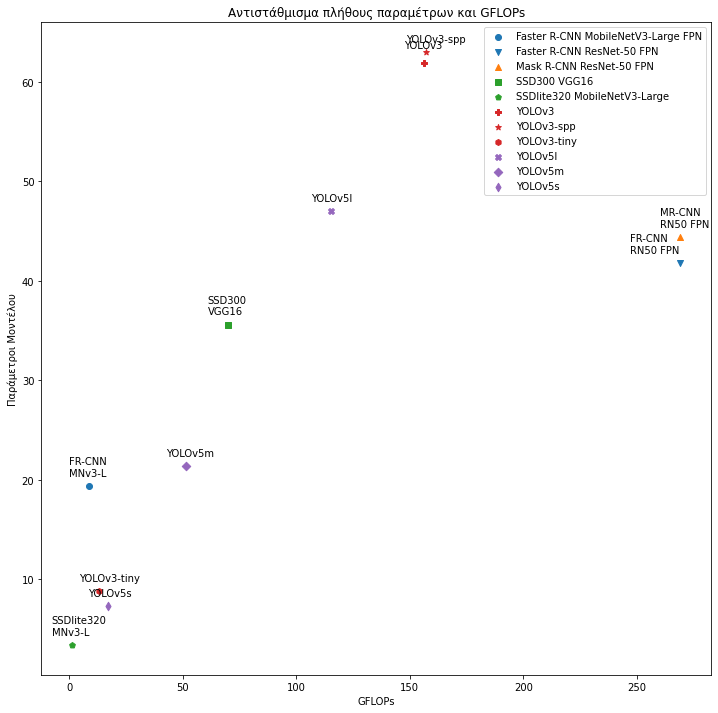

In [ ]:
%matplotlib inline

# Start plotting
plt.figure(figsize=(12,12))

plt.title('Αντιστάθμισμα πλήθους παραμέτρων και GFLOPs')
plt.xlabel('GFLOPs')
plt.ylabel('Παράμετροι Μοντέλου')

for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-50,10) 
  # elif models[i] == 'Mask R-CNN ResNet-50 FPN':
  #   xytext = (5,10)
  elif models[i] == 'YOLOv3':
    xytext = (-20,15) 
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (model_gflops[i], model_params[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(model_gflops[i],model_params[i], marker=markers[i],color=colors[i])

plt.legend(models, scatterpoints=1)

plt.show()

### Sort models based on normalized (fps + mAP) score

In [ ]:
norm_fps = (fps-fps.min())/(fps.max()-fps.min())
norm_mAP = (mAP-mAP.min())/(mAP.max()-mAP.min())

norm_score = norm_fps + norm_mAP

sorted_models = pd.DataFrame()
sorted_models['model'] = models
sorted_models['score'] = norm_score

sorted_models.sort_values(by=['score'], ascending=False)

,model,score
10,YOLOv5s,1.292463
8,YOLOv5l,1.177937
9,YOLOv5m,1.167878
7,YOLOv3-tiny,1.000000
6,YOLOv3-spp,0.993451
5,YOLOv3,0.958014
2,Mask R-CNN ResNet-50 FPN,0.823066
0,Faster R-CNN MobileNetV3-Large FPN,0.819086
1,Faster R-CNN ResNet-50 FPN,0.796699
3,SSD300 VGG16,0.617873
